In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import cv2

import re
import os

from PIL import Image

from sklearn import svm, metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint

import pickle

In [ ]:
good_dir = 'PIM_Dataset/good_piece/'
bad_dir = 'PIM_Dataset/bad_piece/'

In [ ]:
device = torch.device("cuda")

model = models.resnet101(pretrained = True)
extraction_layer = model._modules.get('avgpool')
layer_output_size = 2048

model.to(device)
model.eval()

In [ ]:
def feature_extractor(img, tensor = False):

    custom_transforms = transforms.Compose([transforms.Resize((512, 512)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])])

    image = custom_transforms(img).unsqueeze(0).to(device)
    my_embedding = torch.zeros(1, layer_output_size, 1, 1)

    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    h = extraction_layer.register_forward_hook(copy_data)
    model(image)
    h.remove()

    if tensor:
        return my_embedding
    else:
        return my_embedding.numpy()[0, :, 0, 0]

In [ ]:
#data preperation
def feature_extracted_rgb_array_creator():
    my_array = np.zeros((2055, 2464, 3))
    i = 0
    good_list = []
    for file in os.listdir(good_dir):

        my_array[:,:,i] = cv2.imread(good_dir + file, 0)
        i += 1

        if i == 3:
            i = 0
            img = Image.fromarray(my_array.astype(np.uint8))
            feature_vec = feature_extractor(img, tensor = False)
            good_list.append(feature_vec)

    my_array = np.zeros((2055, 2464, 3))
    i = 0
    bad_list = []
    for file in os.listdir(bad_dir):

        my_array[:,:,i] = cv2.imread(bad_dir + file, 0)
        i += 1

        if i == 3:
            i = 0
            img = Image.fromarray(my_array.astype(np.uint8))
            feature_vec = feature_extractor(img, tensor = False)
            bad_list.append(feature_vec)

    good_array = np.asarray(good_list)
    bad_array = np.asarray(bad_list)

    return good_array, bad_array

def bad_piece_splitter():
    my_array_chared = np.zeros((2055, 2464, 3))
    my_array_metal = np.zeros((2055, 2464, 3))
    my_array_gasket = np.zeros((2055, 2464, 3))

    i = 0
    j = 0
    k = 0

    bad_chared_list = []
    bad_metal_list = []
    bad_gasket_list = []

    for file in os.listdir(bad_dir):
       if re.match('chared', file):
            my_array_chared[:,:,i] = cv2.imread(bad_dir + file, 0)
            i += 1

            if i == 3:
                i = 0
                img = Image.fromarray(my_array_chared.astype(np.uint8))
                feature_vec = feature_extractor(img, tensor = False)
                bad_chared_list.append(feature_vec)

       if re.match('metal', file):
            my_array_metal[:,:,j] = cv2.imread(bad_dir + file, 0)
            j += 1

            if j == 3:
                j = 0
                img = Image.fromarray(my_array_metal.astype(np.uint8))
                feature_vec = feature_extractor(img, tensor = False)
                bad_metal_list.append(feature_vec)

       if re.match('gasket', file):
            my_array_gasket[:,:,k] = cv2.imread(bad_dir + file, 0)
            k += 1

            if k == 3:
                k = 0
                img = Image.fromarray(my_array_gasket.astype(np.uint8))
                feature_vec = feature_extractor(img, tensor = False)
                bad_gasket_list.append(feature_vec)


    bad_chared_array = np.asarray(bad_chared_list)
    bad_metal_array = np.asarray(bad_metal_list)
    bad_gasket_array = np.asarray(bad_gasket_list)

    return bad_chared_array, bad_metal_array, bad_gasket_array

In [ ]:
good_array, bad_array = feature_extracted_rgb_array_creator()

y_good = np.ones((good_array.shape[0]))
y_bad = np.zeros((bad_array.shape[0]))

X_good_bad = np.concatenate((good_array, bad_array))
y_good_bad = np.concatenate((y_good, y_bad))

bad_chared_array, bad_metal_array, bad_gasket_array = bad_piece_splitter()

y_chared = np.zeros((bad_chared_array.shape[0]))
y_metal = np.ones((bad_metal_array.shape[0]))
y_gasket = np.full((bad_gasket_array.shape[0]), 2)

X_bad = np.concatenate((bad_chared_array, bad_metal_array, bad_gasket_array))
y_bad = np.concatenate((y_chared, y_metal, y_gasket))

In [ ]:
def initialize_cnn():
    cnn_model = Sequential()
    cnn_model.add(Dense(256))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(Dense(1, activation='sigmoid'))
    cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy', metrics=['accuracy'])
    return cnn_model

In [ ]:
# Training phases
X_train, X_test, y_train, y_test = train_test_split(
    X_good_bad, y_good_bad, test_size = 0.25, shuffle = True)

epochs = 25
batch_size = 16

cnn_model = initialize_cnn()
cnn_model.fit(X_train, y_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(X_test, y_test),
              callbacks=[ModelCheckpoint('cnn_model_saved.hdf5',
              save_best_only = True, monitor = 'val_loss', mode = 'min')])

In [ ]:
cnn_model.load_weights('cnn_model_saved.hdf5')
y_pred = cnn_model.predict_classes(X_test)

In [ ]:
print('Acuuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred)))
print('F1_score: {}'.format(metrics.f1_score(y_test, y_pred)))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
print('Specificity: {}'.format(specificity))

labels = ['Good', 'Bad']

cfm = confusion_matrix(y_test, y_pred)

plt.imshow(cfm)
for y in range(cfm.shape[0]):
    for x in range(cfm.shape[1]):
        plt.text(x, y, '%.4f' % cfm[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 c='w', weight= 10)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.xlabel(labels)
plt.ylabel(labels)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.title('Confusion Matrix')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_bad, y_bad, test_size = 0.15, shuffle = True)

classifier = svm.SVC(gamma = 'auto', kernel = 'linear')
classifier.fit(X_train, y_train)
pickle.dump(classifier, open('svm_model.sav', 'wb'))

In [ ]:
clasifier = pickle.load(open('svm_model.sav', 'rb'))
y_pred = classifier.predict(X_test)

In [ ]:
print('Acuuracy: {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Precision: {}'.format(metrics.precision_score(y_test, y_pred, average=None)))
print('Recall: {}'.format(metrics.recall_score(y_test, y_pred, average=None)))
print('F1_score: {}'.format(metrics.f1_score(y_test, y_pred, average=None)))

labels = ['Charred', 'Gasket', 'Metal']
cfm = confusion_matrix(y_test, y_pred)

plt.imshow(cfm)
for y in range(cfm.shape[0]):
    for x in range(cfm.shape[1]):
        plt.text(x, y, '%.4f' % cfm[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 c='w', weight= 10)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.xlabel(labels)
plt.ylabel(labels)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.title('Confusion Matrix')
plt.show()

In [ ]:
cnn_model = load_model('cnn_model_saved.hdf5')
svm_model = pickle.load(open('svm_model.sav', 'rb'))

In [ ]:
def interface(image):

    my_dict_g_b = {0:'Bad Piece', 1:'Good Piece'}
    my_dict_b = {0: 'Charred', 1: 'Gasket', 2: 'Metal'}

    my_img = cv2.imread(image)
    my_img = Image.fromarray(my_img.astype(np.uint8))
    m = feature_extractor(my_img).reshape(1, -1)

    cnn_predicted_class = cnn_model.predict_classes(m)[0][0]
    print(my_dict_g_b[cnn_predicted_class])

    if cnn_predicted_class == 0:
        svm_predicted_class = svm_model.predict(m)[0]
        print(my_dict_b[svm_predicted_class])

In [26]:
my_img = 'PIM_Dataset/bad_piece/gasket16_3.bmp'
interface(my_img)

Bad Piece
Gasket


## Testing Section

In [27]:
good_dir_test = 'PIM_Testing/good_piece/'
bad_dir_test = 'PIM_Testing/bad_piece/'

def feature_extracted_rgb_array_creator():
    my_array = np.zeros((2055, 2464, 3))
    i = 0
    good_list = []
    for file in os.listdir(good_dir_test):

        my_array[:,:,i] = cv2.imread(good_dir_test + file, 0)
        i += 1

        if i == 3:
            i = 0
            img = Image.fromarray(my_array.astype(np.uint8))
            feature_vec = feature_extractor(img, tensor = False)
            good_list.append(feature_vec)

    my_array = np.zeros((2055, 2464, 3))
    i = 0
    bad_list = []
    for file in os.listdir(bad_dir_test):

        my_array[:,:,i] = cv2.imread(bad_dir_test + file, 0)
        i += 1

        if i == 3:
            i = 0
            img = Image.fromarray(my_array.astype(np.uint8))
            feature_vec = feature_extractor(img, tensor = False)
            bad_list.append(feature_vec)

    good_array = np.asarray(good_list)
    bad_array = np.asarray(bad_list)

    return good_array, bad_array

good_array_test, bad_array_test = feature_extracted_rgb_array_creator()

In [32]:
y_good_test = np.ones((good_array_test.shape[0]))
y_bad_test = np.zeros((bad_array_test.shape[0]))

X_good_bad_test = np.concatenate((good_array_test, bad_array_test))
y_good_bad_test = np.concatenate((y_good_test, y_bad_test))

In [33]:
y_pred_test = cnn_model.predict_classes(X_good_bad_test)

Acuuracy: 1.0
Precision: 1.0
Recall: 1.0
F1_score: 1.0
Specificity: 1.0


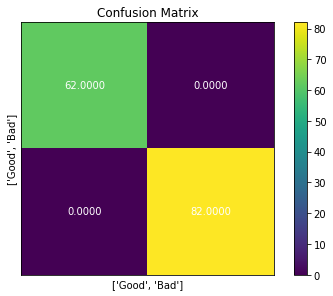

In [34]:
print('Acuuracy: {}'.format(metrics.accuracy_score(y_good_bad_test, y_pred_test)))
print('Precision: {}'.format(metrics.precision_score(y_good_bad_test, y_pred_test)))
print('Recall: {}'.format(metrics.recall_score(y_good_bad_test, y_pred_test)))
print('F1_score: {}'.format(metrics.f1_score(y_good_bad_test, y_pred_test)))
tn, fp, fn, tp = confusion_matrix(y_good_bad_test, y_pred_test).ravel()
specificity = tn / (tn+fp)
print('Specificity: {}'.format(specificity))

labels = ['Good', 'Bad']

cfm = confusion_matrix(y_good_bad_test, y_pred_test)

plt.imshow(cfm)
for y in range(cfm.shape[0]):
    for x in range(cfm.shape[1]):
        plt.text(x, y, '%.4f' % cfm[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 c='w', weight= 10)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.xlabel(labels)
plt.ylabel(labels)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.title('Confusion Matrix')
plt.show()


In [36]:
def bad_piece_splitter():
    my_array_chared = np.zeros((2055, 2464, 3))
    my_array_metal = np.zeros((2055, 2464, 3))
    my_array_gasket = np.zeros((2055, 2464, 3))

    i = 0
    j = 0
    k = 0

    bad_chared_list = []
    bad_metal_list = []
    bad_gasket_list = []

    for file in os.listdir(bad_dir_test):
       if re.match('chared', file):
            my_array_chared[:,:,i] = cv2.imread(bad_dir_test + file, 0)
            i += 1

            if i == 3:
                i = 0
                img = Image.fromarray(my_array_chared.astype(np.uint8))
                feature_vec = feature_extractor(img, tensor = False)
                bad_chared_list.append(feature_vec)

       if re.match('metal', file):
            my_array_metal[:,:,j] = cv2.imread(bad_dir_test + file, 0)
            j += 1

            if j == 3:
                j = 0
                img = Image.fromarray(my_array_metal.astype(np.uint8))
                feature_vec = feature_extractor(img, tensor = False)
                bad_metal_list.append(feature_vec)

       if re.match('gasket', file):
            my_array_gasket[:,:,k] = cv2.imread(bad_dir_test + file, 0)
            k += 1

            if k == 3:
                k = 0
                img = Image.fromarray(my_array_gasket.astype(np.uint8))
                feature_vec = feature_extractor(img, tensor = False)
                bad_gasket_list.append(feature_vec)


    bad_chared_array = np.asarray(bad_chared_list)
    bad_metal_array = np.asarray(bad_metal_list)
    bad_gasket_array = np.asarray(bad_gasket_list)

    return bad_chared_array, bad_metal_array, bad_gasket_array

In [37]:
bad_chared_array_test, bad_metal_array_test, bad_gasket_array_test = bad_piece_splitter()

y_chared_test = np.zeros((bad_chared_array_test.shape[0]))
y_metal_test = np.ones((bad_metal_array_test.shape[0]))
y_gasket_test = np.full((bad_gasket_array_test.shape[0]), 2)

X_bad_test = np.concatenate((bad_chared_array_test, bad_metal_array_test, bad_gasket_array_test))
y_bad_test = np.concatenate((y_chared_test, y_metal_test, y_gasket_test))

In [38]:
y_pred_test = classifier.predict(X_bad_test)

Acuuracy: 0.7419354838709677
Precision: [0.88888889 0.67647059 0.7       ]
Recall: [0.66666667 0.88461538 0.58333333]
F1_score: [0.76190476 0.76666667 0.63636364]


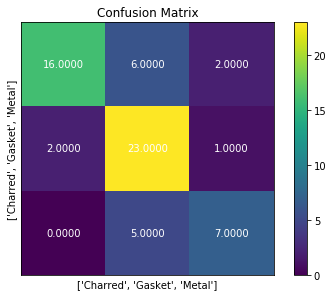

In [39]:
print('Acuuracy: {}'.format(metrics.accuracy_score(y_bad_test, y_pred_test)))
print('Precision: {}'.format(metrics.precision_score(y_bad_test, y_pred_test, average=None)))
print('Recall: {}'.format(metrics.recall_score(y_bad_test, y_pred_test, average=None)))
print('F1_score: {}'.format(metrics.f1_score(y_bad_test, y_pred_test, average=None)))

labels = ['Charred', 'Gasket', 'Metal']
cfm = confusion_matrix(y_bad_test, y_pred_test)

plt.imshow(cfm)
for y in range(cfm.shape[0]):
    for x in range(cfm.shape[1]):
        plt.text(x, y, '%.4f' % cfm[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 c='w', weight= 10)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.xlabel(labels)
plt.ylabel(labels)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.title('Confusion Matrix')
plt.show()